### Gene expression vs 3D changes during Legionella infection
**cmdoret**


In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. 

In [1]:

import os
import re
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import pyranges as pr
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
from pandarallel import pandarallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
from skimage import filters
import statsmodels.api as sm

os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [2]:
diff_expr = pd.read_csv('data/output/diff_expr/c3_diff_expr.tsv', sep='\t')
diff_expr = diff_expr.reset_index(drop=False)
diff_expr = diff_expr.rename(columns={'index': 'accession'})
# Load relevant columns from annotation file and select mRNA only
annot = (
    pd.read_csv(
        'data/input/annotations/c3_annotations/Acanthamoeba_castellanii_C3.gff3',
        sep='\t',
        comment='#',
        header=None,
        usecols=[0, 2, 3, 4, 8],
        names=['chrom', 'type', 'start', 'end', 'attr'])
    .query('type=="mRNA"')
)
annot['accession'] = annot['attr'].str.replace(r'ID=([^;]*)\.mRNA\.[0-9]+;.*', r'\1')
# For each gene, retain only the longest transcript (to remove redundancy)
annot['length']= annot['end'] - annot['start']
annot = (
    annot
    .sort_values('length', )
    .groupby('accession')
    .head(1)
    .sort_values(['chrom', 'start', 'end'])
    .reset_index(drop=True)
)
# Extract functinoal annotations as individual columns
annot['desc'] = annot['attr'].str.replace(r'.*product=([^;]*);.*', r'\1')
annot['IPR'] = annot['attr'].apply(lambda s: re.findall(r'InterPro:(IPR[0-9]+)', s))
annot['PFAM'] = annot['attr'].apply(lambda s: re.findall(r'PFAM:(PF[0-9]+)', s))
#annot[['IPR', 'PFAM']] = annot[['IPR', 'PFAM']].applymap(lambda l: l if len(l) else np.nan)

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.


In [3]:
annot

,chrom,type,start,end,attr,accession,length,desc,IPR,PFAM
0,scaffold_1,mRNA,504,5457,ID=VMHBD_00001.mRNA.1;Parent=VMHBD_00001;produ...,VMHBD_00001,4953,hypothetical protein,"[IPR027417, IPR001806, IPR020849, IPR005225, I...","[PF00071, PF08477, PF00651]"
1,scaffold_1,mRNA,5352,9953,ID=VMHBD_00002.mRNA.1;Parent=VMHBD_00002;produ...,VMHBD_00002,4601,hypothetical protein,[],[]
2,scaffold_1,mRNA,9877,10656,ID=VMHBD_00003.mRNA.1;Parent=VMHBD_00003;produ...,VMHBD_00003,779,hypothetical protein,[IPR017920],[PF07258]
3,scaffold_1,mRNA,10702,11622,ID=VMHBD_00004.mRNA.1;Parent=VMHBD_00004;produ...,VMHBD_00004,920,hypothetical protein,[],[]
4,scaffold_1,mRNA,11710,30748,ID=VMHBD_00005.mRNA.2;Parent=VMHBD_00005;produ...,VMHBD_00005,19038,hypothetical protein,"[IPR001876, IPR003877, IPR000569, IPR013320, I...","[PF00622, PF00076, PF00632]"
...,...,...,...,...,...,...,...,...,...,...
16885,scaffold_97,mRNA,5588,6107,ID=VMHBD_16886.mRNA.1;Parent=VMHBD_16886;produ...,VMHBD_16886,519,hypothetical protein,[],[]
16886,scaffold_97,mRNA,7070,7516,ID=VMHBD_16887.mRNA.1;Parent=VMHBD_16887;produ...,VMHBD_16887,446,hypothetical protein,"[IPR001584, IPR012337]",[]
16887,scaffold_99,mRNA,701,2228,ID=VMHBD_16888.mRNA.1;Parent=VMHBD_16888;produ...,VMHBD_16888,1527,hypothetical protein,"[IPR003613, IPR013083]",[PF04564]
16888,scaffold_99,mRNA,3089,4240,ID=VMHBD_16889.mRNA.1;Parent=VMHBD_16889;produ...,VMHBD_16889,1151,hypothetical protein,[],[]


First, let's visualize the differential expression of genes at 5h p.i. vs uninfected control using a volcano plot:

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


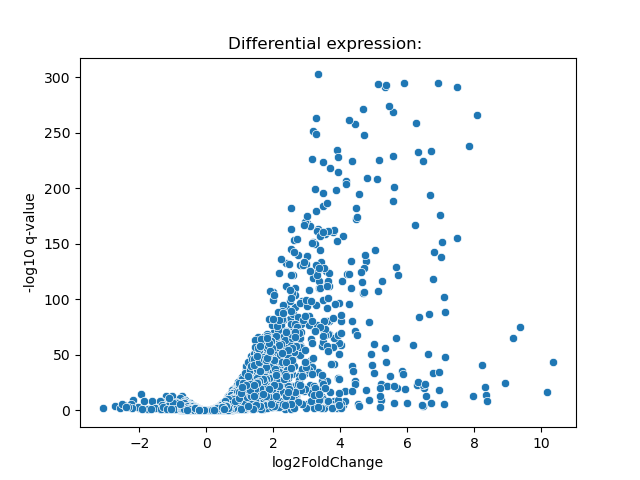

Text(0.5, 1.0, 'Differential expression: ')

In [4]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")
plt.title("Differential expression: ")

Let's subset genes which are highly differentially expressed at 5h p.i. to match the Hi-C dataset.


In [5]:
PADJ_THRESH = 0.05
L2FC_THRESH = 0

<IPython.core.display.Javascript object>


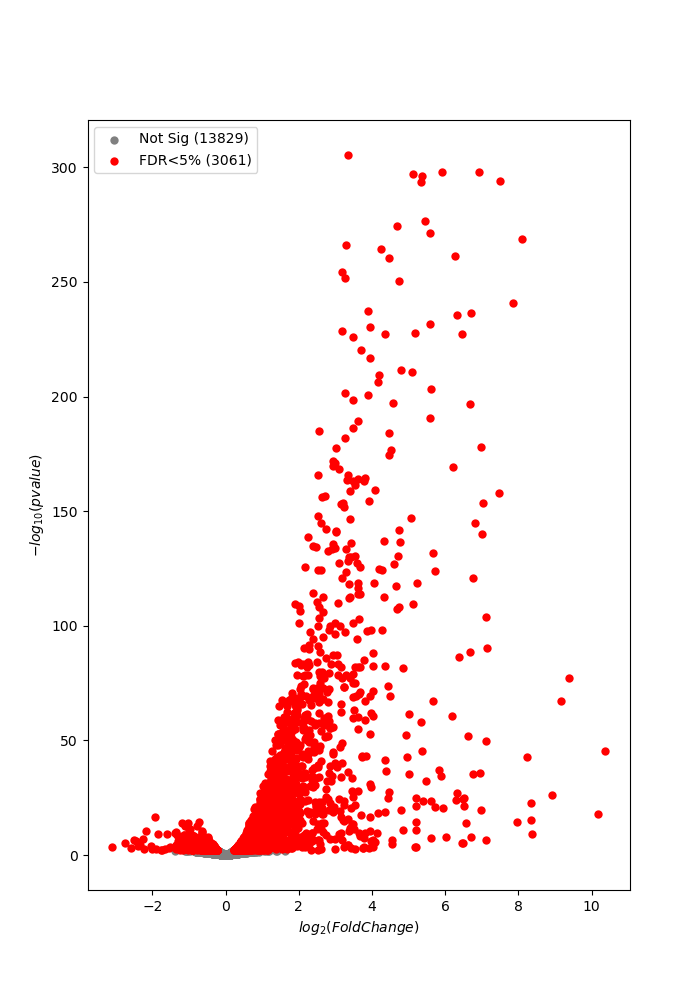

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
def plot_volcano(data, adjust=False, **kwargs):
    plt.figure(figsize=(7, 10))
    mask = (data['log2FoldChange'].abs() > L2FC_THRESH) & (data['padj'] < PADJ_THRESH)
    xns, yns = data['log2FoldChange'][~mask], -np.log10(data['pvalue'][~mask])
    plt.scatter(xns, yns, c='grey', edgecolor=(1,1,1,0), label=f'Not Sig ({len(xns)})')
    xs, ys = data['log2FoldChange'][mask], -np.log10(data['pvalue'][mask])
    plt.scatter(xs, ys, c='r', edgecolor=(1,1,1,0), label=f'FDR<5% ({len(xs)})')
    texts = []
    #for x, y, l in zip(xs, ys, data['accession'][mask]):
        #texts.append(plt.text(x, y, l, size=8))
    plt.legend()
    plt.xlabel('$log_2(Fold Change)$')
    plt.ylabel('$-log_{10}(pvalue)$')
    if adjust:
        plt.title('%s iterations' % adjust_text(texts,
                                                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), **kwargs))
_ = plot_volcano(diff_expr)


Log differential expression values are highly skewed towards positive values, with a high number of differentially expressed genes. (~18%)

In [7]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [8]:
sig_expr

,accession,baseMean,log2FoldChange,lfcSE,pvalue,padj
3251,VMHBD_03252,14503.268479,4.103388,0.106392,0.000000,0.000000
4012,VMHBD_04013,15938.577436,5.643853,0.122156,0.000000,0.000000
6240,VMHBD_06241,23666.251237,6.015194,0.126071,0.000000,0.000000
8516,VMHBD_08517,9441.092499,10.453675,0.267838,0.000000,0.000000
15222,VMHBD_15223,13312.719750,4.798848,0.116908,0.000000,0.000000
...,...,...,...,...,...,...
7353,VMHBD_07354,545.202717,0.376638,0.151056,0.009376,0.049590
7678,VMHBD_07679,2404.365963,0.281852,0.111146,0.009401,0.049689
7482,VMHBD_07483,728.466680,-0.387732,0.156700,0.009400,0.049689
7436,VMHBD_07437,1336.854296,0.247234,0.096835,0.009413,0.049736


In [9]:
sig_expr = sig_expr.merge(annot, on='accession', how='left').sort_values('padj')
sig_expr = sig_expr.dropna()
sig_expr.start = sig_expr.start.astype(int)
sig_expr.end = sig_expr.end.astype(int)
sig_expr = sig_expr.drop_duplicates(subset=['accession']).reset_index(drop=True)

In [10]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 3061 genes (18.12%)  with more than 0 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, the homologous gene in our assembly is VMHBD_08871. Let's have a look at these.

In [11]:
sig_expr.loc[sig_expr.accession ==  'VMHBD_08871', :]

,accession,baseMean,log2FoldChange,lfcSE,pvalue,padj,chrom,type,start,end,attr,length,desc,IPR,PFAM
11,VMHBD_08871,47873.264078,7.954979,0.120793,0.0,0.0,scaffold_24,mRNA,875550,878343,ID=VMHBD_08871.mRNA.2;Parent=VMHBD_08871;produ...,2793,hypothetical protein,"[IPR003000, IPR026590, IPR029035, IPR001607, I...","[PF02148, PF02146]"


It is indeed in our top differentially expressed gene list. 

### Computing gene-based statistics from Hi-C data

So if we want to associate expression data to Hi-C data, we need to tie contact values to individual genes.
What I will do here is retrieve contact values between all pairs of genes before and after infection (2 replicates each). For every gene pair, I will then compute a contact change score (ratio, t-test, ...).
This will give us an interaction change network of NxN genes. I will then see how interaction change relate to co-expression using the RNAseq.

> Note: All this will be done on the normalized and detrended matrix to correct for accessibility and genomic distance.

In [12]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/sub_uninfected.mcool::/resolutions/2000')
clr_inf = cooler.Cooler('data/output/cool/sub_infected.mcool::/resolutions/2000')

In [13]:
def get_contact_gene_pairs2(clr: cooler.Cooler, genes: pd.DataFrame, intra=False) -> pd.DataFrame:
    """ Compute average contacts between all gene pairs"""
    if intra:
        combs = []
        for chrom in clr.chroms()[:]['name']:
            combs += list(it.combinations(genes.accession[genes.chrom==chrom], 2))
        combs = pd.DataFrame((combs))
    else:
        combs = pd.DataFrame((it.combinations(genes.accession, 2)))
    combs.columns = ['g1', 'g2']
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g1')
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g2')    
    combs = combs.drop(columns=['g1', 'g2'])
    
    def avg_contacts(r):
        mat = clr.matrix(balance=True, sparse=False).fetch(
            f'{r.chrom_x}:{r.start_x}-{r.end_x}',
            f'{r.chrom_y}:{r.start_y}-{r.end_y}'
        )
        return np.nanmean(mat)
    mean_contacts = combs.parallel_apply(avg_contacts, axis=1)
    combs['mean_contacts'] = mean_contacts
    return combs
    

Now I use chromosight to compute normalized + detrended contacts between all pairs of genes.

In [14]:
pandarallel.initialize(progress_bar=True)
p_hic = get_contact_gene_pairs2(clr_ctl, annot, intra=True)
p_hic = (
    p_hic
    .rename(columns=lambda c: re.sub(r'_x$', '1', c))
    .rename(columns=lambda c: re.sub(r'_y$', '2', c))
)
p_hic = p_hic.rename(columns={'mean_contacts': 'ctl_contacts'})
p_hic['inf_contacts'] = get_contact_gene_pairs2(clr_inf, annot, intra=True)['mean_contacts']


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


When visualising the results, it seems that genes differentially expressed at 8h p.i. do not have stronger contacts change during infection than the rest of the genome. The histogram below shows the proportion of contact change during infection (5h pi).

> Note: Only gene pairs where both genes have nonzero contacts in both conditions (uninfected or infected) were shown.

In [15]:
p_hic.head()

,chrom1,start1,end1,accession1,chrom2,start2,end2,accession2,ctl_contacts,inf_contacts
0,scaffold_1,504,5457,VMHBD_00001,scaffold_1,5352,9953,VMHBD_00002,0.042424,0.031779
1,scaffold_1,504,5457,VMHBD_00001,scaffold_1,9877,10656,VMHBD_00003,0.038945,0.032291
2,scaffold_1,5352,9953,VMHBD_00002,scaffold_1,9877,10656,VMHBD_00003,0.051581,0.034323
3,scaffold_1,504,5457,VMHBD_00001,scaffold_1,10702,11622,VMHBD_00004,0.038855,0.030869
4,scaffold_1,5352,9953,VMHBD_00002,scaffold_1,10702,11622,VMHBD_00004,0.037412,0.036260


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


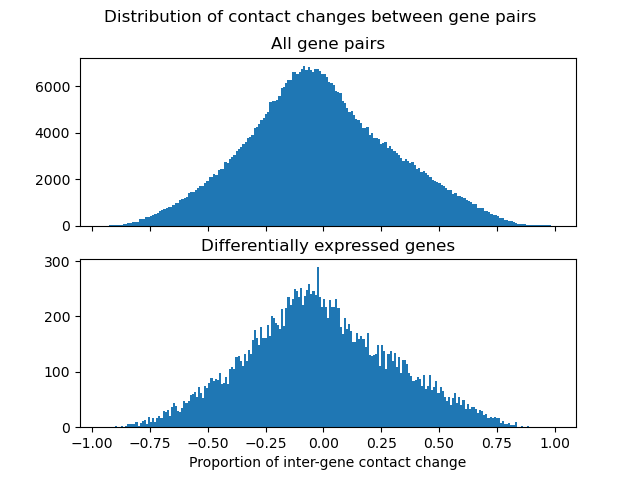

Text(0.5, 0, 'Proportion of inter-gene contact change')

In [16]:
%matplotlib notebook
de_nnz_hic = p_hic.loc[
    p_hic.accession1.isin(sig_expr.accession) &
    p_hic.accession2.isin(sig_expr.accession) &
    (p_hic.inf_contacts > 0) &
    (p_hic.ctl_contacts > 0),
    :
]
de_nnz_hic.prop_change = (de_nnz_hic.inf_contacts - de_nnz_hic.ctl_contacts) / (de_nnz_hic.inf_contacts + de_nnz_hic.ctl_contacts)

nnz_hic = p_hic.loc[(p_hic.ctl_contacts > 0) & (p_hic.inf_contacts) > 0, :]
nnz_hic.prop_change = (nnz_hic.inf_contacts - nnz_hic.ctl_contacts) / (nnz_hic.inf_contacts + nnz_hic.ctl_contacts)

fig, ax = plt.subplots(2, 1, sharex=True)
f = ax[0].hist(
    (nnz_hic.prop_change),
    200
)
f = ax[1].hist(
    (de_nnz_hic.prop_change),
    200
)


plt.suptitle("Distribution of contact changes between gene pairs")
ax[0].set_title("All gene pairs")
ax[1].set_title("Differentially expressed genes")
ax[1].set_xlabel('Proportion of inter-gene contact change')

In [17]:
print(
    f'The differentially expressed do not have significantly stronger contact changes than the rest of the genome. Mann whitney U : {ss.mannwhitneyu(abs(nnz_hic.prop_change), abs(de_nnz_hic.prop_change))}'
)

The differentially expressed do not have significantly stronger contact changes than the rest of the genome. Mann whitney U : MannwhitneyuResult(statistic=4820581867.5, pvalue=0.24677559854562892)


In [18]:
nnz_gene_pairs = nnz_hic.shape[0]
nnz_inter_pairs = nnz_hic.loc[nnz_hic.chrom1 != nnz_hic.chrom2, :].shape[0]
print(f'There are {nnz_gene_pairs} gene pairs with nonzero contacts (out of {p_hic.shape[0]}).'
      f' {nnz_inter_pairs} of these are interchromosomal'
)

There are 497895 gene pairs with nonzero contacts (out of 4209144). 0 of these are interchromosomal


When visualizing the pairwise gene-gene contact matrix, we see clusters appearing along the diagonal.
This confirms that genes closer to each other make more contacts with each other.

In [19]:
p_hic

,chrom1,start1,end1,accession1,chrom2,start2,end2,accession2,ctl_contacts,inf_contacts
0,scaffold_1,504,5457,VMHBD_00001,scaffold_1,5352,9953,VMHBD_00002,0.042424,0.031779
1,scaffold_1,504,5457,VMHBD_00001,scaffold_1,9877,10656,VMHBD_00003,0.038945,0.032291
2,scaffold_1,5352,9953,VMHBD_00002,scaffold_1,9877,10656,VMHBD_00003,0.051581,0.034323
3,scaffold_1,504,5457,VMHBD_00001,scaffold_1,10702,11622,VMHBD_00004,0.038855,0.030869
4,scaffold_1,5352,9953,VMHBD_00002,scaffold_1,10702,11622,VMHBD_00004,0.037412,0.036260
...,...,...,...,...,...,...,...,...,...,...
4209139,scaffold_36,87530,88387,VMHBD_12678,scaffold_36,98974,100318,VMHBD_12683,NaN,NaN
4209140,scaffold_36,88423,89378,VMHBD_12679,scaffold_36,98974,100318,VMHBD_12683,NaN,NaN
4209141,scaffold_36,89713,90505,VMHBD_12680,scaffold_36,98974,100318,VMHBD_12683,NaN,NaN
4209142,scaffold_36,90829,95841,VMHBD_12681,scaffold_36,98974,100318,VMHBD_12683,NaN,NaN


<IPython.core.display.Javascript object>


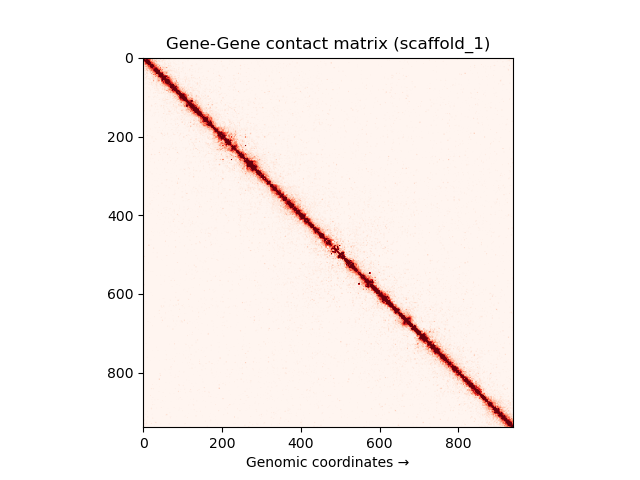

Text(0.5, 0, 'Genomic coordinates →')

In [24]:
%matplotlib notebook
p_hic_sym = pd.concat([
    p_hic.query('(chrom1 == "scaffold_1") & (chrom2 == "scaffold_1")'), (
    p_hic
    .query('(chrom1 == "scaffold_1") & (chrom2 == "scaffold_1")')
    .rename(columns=lambda c: re.sub(r'1$', r'3', c))
    .rename(columns=lambda c: re.sub(r'2$', r'1', c))
    .rename(columns=lambda c: re.sub(r'3$', r'2', c))
    .loc[:, p_hic.columns]
    )]
)
hic_mat = p_hic_sym.sort_values(['chrom1', 'chrom2', 'start1', 'start2']).loc[:, ['accession1', 'accession2', 'ctl_contacts']].pivot('accession1', 'accession2').fillna(0)
hic_mat.columns = [o[1] for o in hic_mat.columns]
ord_genes = [g for g in annot.sort_values(['chrom', 'start']).accession if g in hic_mat.columns]
hic_mat = hic_mat.loc[ord_genes, :].loc[:, ord_genes]
hic_mat = hic_mat.to_numpy() + hic_mat.to_numpy().T
plt.imshow(np.log1p(hic_mat), vmax = np.percentile(np.log1p(hic_mat), 99.), cmap='Reds')
plt.title('Gene-Gene contact matrix (scaffold_1)')
plt.xlabel('Genomic coordinates →')

We can also visualize the detrended contacts vs genomic distance plot, showing a contact enrichment between pairs of genes spaced by ~10kb.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


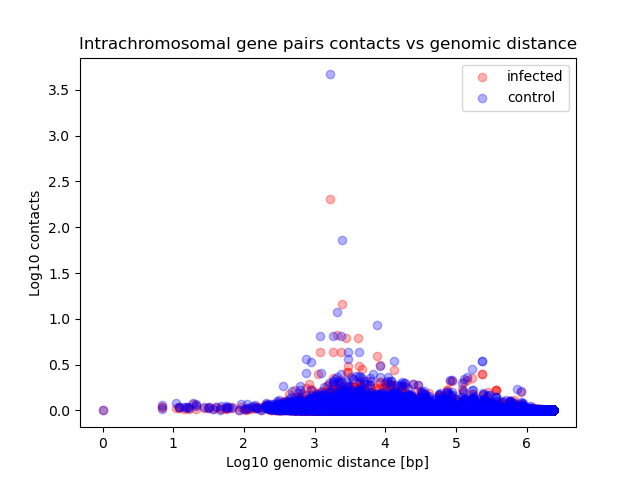

In [25]:
%matplotlib notebook
cis_hic = p_hic.loc[p_hic.chrom1 == p_hic.chrom2, :]
plt.scatter(np.log10(abs(cis_hic.start2 - cis_hic.start1)), cis_hic.inf_contacts, c='red', alpha=0.3, label='infected')
plt.scatter(np.log10(abs(cis_hic.start2 - cis_hic.start1)), cis_hic.ctl_contacts, c='blue', alpha=0.3, label='control')
plt.title("Intrachromosomal gene pairs contacts vs genomic distance")
plt.ylabel("Log10 contacts")
plt.xlabel("Log10 genomic distance [bp]")
plt.legend()

## Infection vs chromatin loops

The genome of _A. castellanii_ is spanned by numerous regularly spaced chromatin loops. Are they linked to gene expression ?

In [26]:
loops = pd.read_csv('data/output/chromosight/merged_contacts/loops_out.tsv', sep='\t')
borders = pd.read_csv('data/output/chromosight/merged_contacts/borders_out.tsv', sep='\t')

anchors = (
    pd.concat([
        loops[['chrom1', 'start1', 'end1', 'score']].rename(columns=lambda x: re.sub('1$','', x)),
        loops[['chrom2', 'start2', 'end2', 'score']].rename(columns=lambda x: re.sub('2$', '', x)),
    ])
    .sort_values(['chrom', 'start', 'score'])
    .drop_duplicates(subset=['chrom', 'start', 'end'])
    .reset_index(drop=True)
    .rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'})
)

In [27]:
import pyranges as pr
annot_pr = pr.PyRanges(annot.rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'}))
loops_pr = pr.PyRanges(anchors)
expr_dist = (
    loops_pr
    .nearest(annot_pr)
    .df
    .loc[:, ['accession', 'Distance', 'score']]
    .merge(diff_expr[['accession', 'baseMean', 'log2FoldChange', 'pvalue']])
    .dropna()
)
no_loop = expr_dist.Distance > 0

Genes on a chromatin loop anchor are more strongly expressed on average and more differentially expressed during infection. This may suggest that loops occur both at house-keeping genes which are generally stable and strongly expressed, and genes that change during infection (of potential regulatory importance).

In [28]:
def add_ssize_ax(grouping, values, ax, shift=0.5):
    """Annotates sample size on an input plot"""
    # Calculate number of obs per group & median to position labels
    groups = np.unique(grouping)
    medians = [np.median(values[grouping==g]) for g in groups]
    nobs = [len(grouping[grouping==g]) for g in groups]
    nobs = [str(x) for x in nobs]
    nobs = ["n: " + i for i in nobs]
 
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
            medians[tick] + shift,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')

<IPython.core.display.Javascript object>


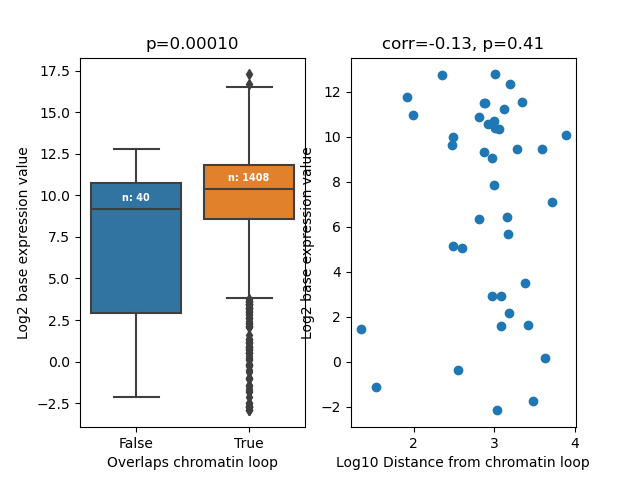

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [86]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)
# Base expression vs loop overlap
sns.boxplot(~no_loop, np.log2(expr_dist.baseMean), ax=ax[0])
add_ssize_ax(~no_loop, np.log2(expr_dist.baseMean), ax[0])
ax[0].set_xlabel('Overlaps chromatin loop')
ax[0].set_ylabel('Log2 base expression value')
stat = ss.mannwhitneyu(np.log2(expr_dist.baseMean[~no_loop]), np.log2(expr_dist.baseMean[no_loop]))
ax[0].set_title(f'p={stat[1]:.5f}')

# Base expression vs distance from loop
ax[1].scatter(np.log10(expr_dist.Distance[no_loop]), np.log2(expr_dist.baseMean[no_loop]))
ax[1].set_xlabel("Log10 Distance from chromatin loop")
ax[1].set_ylabel("Log2 base expression value")
corr = ss.spearmanr(np.log10(expr_dist.Distance[no_loop]), np.log2(expr_dist.baseMean[no_loop]))
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

<IPython.core.display.Javascript object>


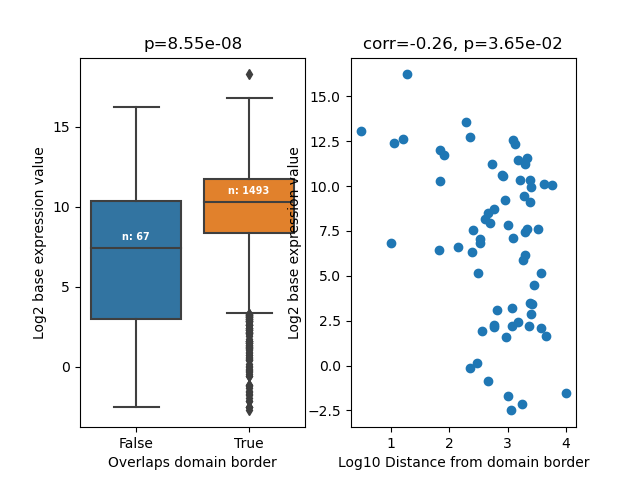

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [87]:
%matplotlib notebook

borders_pr = pr.PyRanges(borders.rename(columns={'chrom1': 'Chromosome', 'start1': 'Start', 'end1': 'End'}))
border_expr_dist = (
    borders_pr
    .nearest(annot_pr)
    .df
    .loc[:, ['accession', 'Distance', 'score']]
    .merge(diff_expr[['accession', 'baseMean', 'log2FoldChange', 'pvalue']])
    .dropna()
)
no_border = border_expr_dist.Distance > 0
fig, ax = plt.subplots(1, 2)
feat = np.log2(border_expr_dist.baseMean)
# Base expression according to border overlap
sns.boxplot(~no_border, feat, ax=ax[0])
add_ssize_ax(~no_border, feat, ax[0])
ax[0].set_xlabel('Overlaps domain border')
ax[0].set_ylabel('Log2 base expression value')
stat = ss.mannwhitneyu(feat[~no_border], feat[no_border])
ax[0].set_title(f'p={stat[1]:.2e}')

# Base expression vs border distance
ax[1].scatter(np.log10(border_expr_dist.Distance[no_border]), feat[no_border])
ax[1].set_xlabel("Log10 Distance from domain border")
ax[1].set_ylabel("Log2 base expression value")
corr = ss.spearmanr(np.log10(border_expr_dist.Distance[no_border]), feat[no_border])
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2e}')

<IPython.core.display.Javascript object>


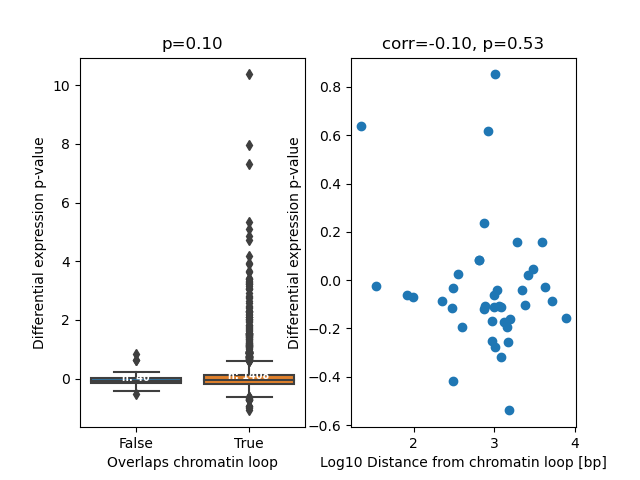

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [88]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)

feat = expr_dist.log2FoldChange
sns.boxplot(~no_loop, feat, ax=ax[0])
add_ssize_ax(~no_loop, feat, ax=ax[0], shift=0.01)
ax[0].set_xlabel('Overlaps chromatin loop')
ax[0].set_ylabel('Differential expression p-value')
stat = ss.mannwhitneyu(feat[~no_loop], feat[no_loop])
ax[0].set_title(f'p={stat[1]:.2f}')
ax[1].scatter(np.log10(expr_dist.Distance[no_loop]), feat[no_loop])
ax[1].set_xlabel("Log10 Distance from chromatin loop [bp]")
ax[1].set_ylabel("Differential expression p-value")
corr = ss.spearmanr(np.log10(expr_dist.Distance[no_loop]), feat[no_loop])
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

<IPython.core.display.Javascript object>


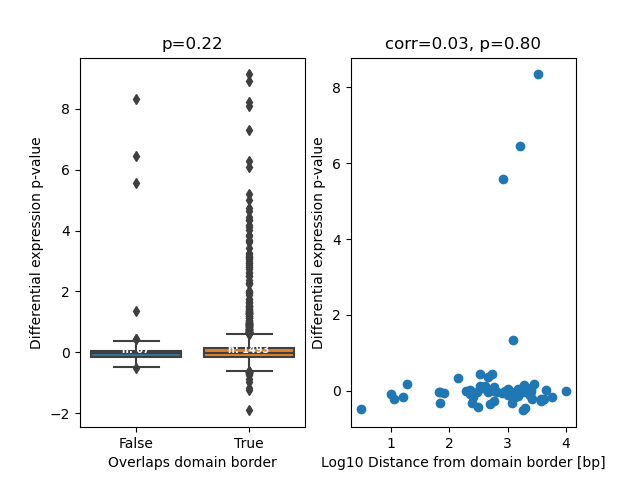

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [89]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)

feat = border_expr_dist.log2FoldChange
sns.boxplot(~no_border, feat, ax=ax[0])
add_ssize_ax(~no_border, feat, ax=ax[0], shift=0.01)
ax[0].set_xlabel('Overlaps domain border')
ax[0].set_ylabel('Differential expression p-value')
stat = ss.mannwhitneyu(feat[~no_border], feat[no_border])
ax[0].set_title(f'p={stat[1]:.2f}')
ax[1].scatter(np.log10(border_expr_dist.Distance[no_border]), feat[no_border])
ax[1].set_xlabel("Log10 Distance from domain border [bp]")
ax[1].set_ylabel("Differential expression p-value")
corr = ss.spearmanr(np.log10(border_expr_dist.Distance[no_border]), feat[no_border])
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

<IPython.core.display.Javascript object>


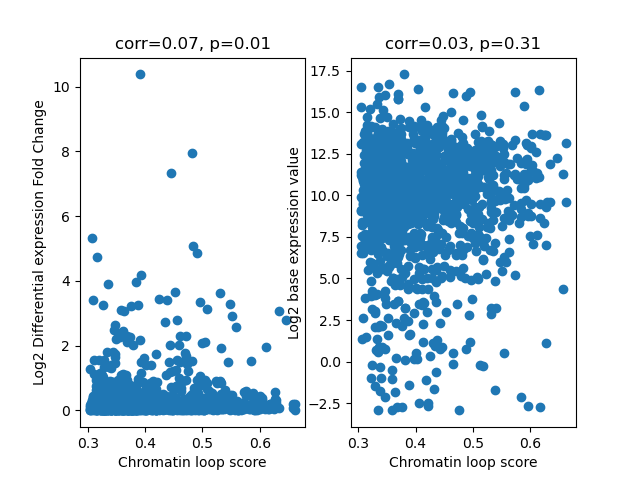

Text(0.5, 1.0, 'corr=0.03, p=0.31')

In [80]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)

feat = expr_dist.log2FoldChange.abs()
ax[0].scatter(expr_dist.score, feat)
ax[0].set_xlabel("Chromatin loop score")
ax[0].set_ylabel("Log2 Differential expression Fold Change")
corr = ss.spearmanr(expr_dist.score, feat)
ax[0].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

feat = np.log2(expr_dist.baseMean)
ax[1].scatter(expr_dist.score, feat)
ax[1].set_xlabel("Chromatin loop score")
ax[1].set_ylabel("Log2 base expression value")
corr = ss.spearmanr(expr_dist.score, feat)
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

<IPython.core.display.Javascript object>


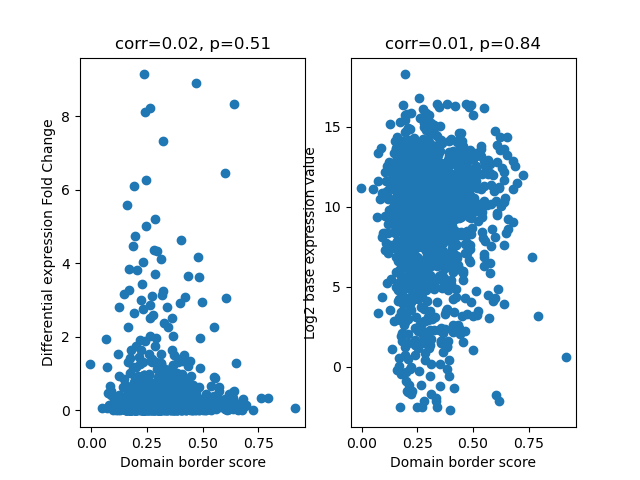

In [83]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)

feat = border_expr_dist.log2FoldChange.abs()
ax[0].scatter(border_expr_dist.score, feat)
ax[0].set_xlabel("Domain border score")
ax[0].set_ylabel("Differential expression Fold Change")
corr = ss.spearmanr(border_expr_dist.score, feat)
ax[0].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

feat = np.log2(border_expr_dist.baseMean)
ax[1].scatter(border_expr_dist.score, feat)
ax[1].set_xlabel("Domain border score")
ax[1].set_ylabel("Log2 base expression value")
corr = ss.spearmanr(border_expr_dist.score, feat)
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

Genes close to borders are more highly expressed. Genes overlapping loops tend to have stronger differential expression during infection, but the effect is not very strong. Higher chromatin loop scores are associated with lower differential expression p-values, but again, the effect is weak and may not be relevant.

## Differential patterns vs differential expression

Now that we know expression value is associated with patterns, we will measure whether they are correlated during infection.

In [81]:
diff_loops = pd.read_csv(
    'data/output/pareidolia/loops_diff_genes.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'x', 'score', 'accession']
).merge(diff_expr, on='accession', how='left')
diff_borders = pd.read_csv(
    'data/output/pareidolia/borders_diff_genes.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'x', 'score', 'accession']
).merge(diff_expr, on='accession', how='left')

The global correlation between differential expression and border change is weak, however it seems to be affecting mostly genes with very high levels of overexpression. We can see that by comparing the top 5% DE genes agains the rest:

<IPython.core.display.Javascript object>


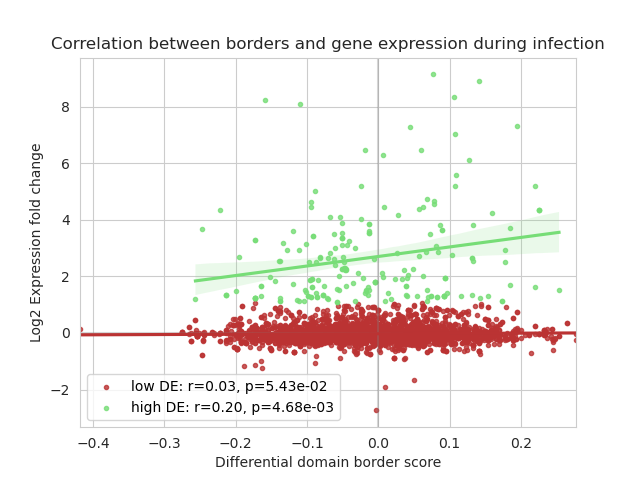

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [520]:
%matplotlib notebook
x = diff_borders.score
y = diff_borders.log2FoldChange
thresh = np.nanpercentile(y, 95)

mask_low = ~np.isnan(x) & ~np.isnan(y) & (y < thresh)
x_low, y_low = x[mask_low], y[mask_low]
r_low, p_low = ss.spearmanr(x_low, y_low)

mask_high = ~np.isnan(x) & ~np.isnan(y) & (y >= thresh)
x_high, y_high = x[mask_high], y[mask_high]
r_high, p_high = ss.spearmanr(x_high, y_high)


with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1)
plt.axvline(0, c='gray', alpha=0.3)
plt.axhline(0, c='gray', alpha=0.3)
sns.regplot(x_low, y_low, ax=ax, color='#BB3333', marker='.', label=f'low DE: r={r_low:.2f}, p={p_low:.2e}')
sns.regplot(x_high, y_high, ax=ax, color='#77DD77', marker='.', label=f'high DE: r={r_high:.2f}, p={p_high:.2e}')
plt.legend()
plt.title(f'Correlation between borders and gene expression during infection')
plt.xlabel("Differential domain border score")
plt.ylabel("Log2 Expression fold change")

When testing this for different subsets of highly expressed genes, we see that the effect seems to indeed appear only for the top 5% most deregulated genes. This could either mean that only highly transcribed borders have an effect on chromatin insulation, or that we reach the detection limit with the Hi-C coverage / resolution.

<IPython.core.display.Javascript object>


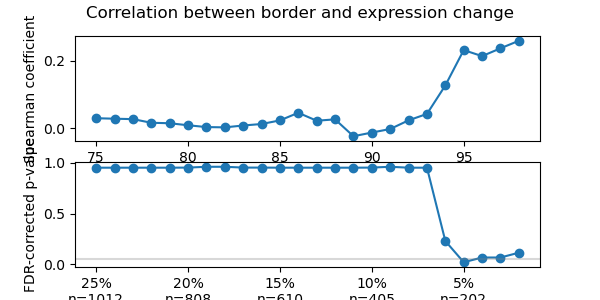

In [561]:
%matplotlib notebook
pos = diff_borders.loc[:,]
import statsmodels.stats.multitest
pos['de_quantile'] = pos['log2FoldChange'].abs().rank(pct=True)
threshs, corrs, pvals = [], [], []
for i in np.arange(75, 99, 1):
    curr = pos.loc[pos.de_quantile >= i/100, :]
    threshs.append(i)
    r, p = ss.spearmanr(curr.score, curr.log2FoldChange)
    corrs.append(r)
    pvals.append(p)
    
fig, ax = plt.subplots(2, 1, figsize=(6, 3))
# Plot quantile threshold vs corr(DE, border change)
ax[0].scatter(threshs, corrs)
ax[0].plot(threshs, corrs)
ax[0].set_ylabel("Spearman coefficient")
# Same for FDR-corrected P-values
_, pvals, _, _ = statsmodels.stats.multitest.multipletests(pvals, alpha = 0.05, method = 'fdr_bh') 
ax[1].scatter(threshs, pvals)
ax[1].plot(threshs, pvals)
ax[1].axhline(0.05, color='grey', alpha=0.3)
ax[1].set_xlabel("Top % DE genes")
ax[1].set_ylabel("FDR-corrected p-value")
plt.suptitle("Correlation between border and expression change")

# Add # genes to axis ticks
def update_ticks(x, pos, df=pos):
    n_genes = (100*df.de_quantile >= x).sum()
    return str(100-int(x)) + "%\n" + f"n={n_genes}"

import matplotlib.ticker as mticker
ax[1].xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

plt.savefig('/home/cmatthey/pCloudDrive/reports_phd/20200617_acastellanii_ms/figures/assets/20210812_3d_vs_expr/threshold_diff_border_score_diff_expr.svg')

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


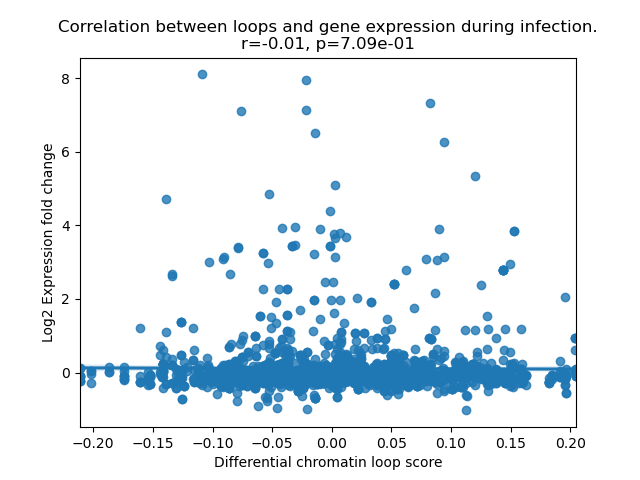

Text(0, 0.5, 'Log2 Expression fold change')

In [366]:
%matplotlib notebook
x = diff_loops.score
y = diff_loops.log2FoldChange
p = diff_loops.padj
mask = ~np.isnan(x) & ~np.isnan(y)
x, y, p = x[mask], y[mask], p[mask]
#x, y = x[p<0.05], y[p<0.05]
r, p = ss.spearmanr(x, y)
sns.regplot(x, y)
plt.title(f'Correlation between loops and gene expression during infection.\nr={r:.2f}, p={p:.2e}')
plt.xlabel("Differential chromatin loop score")
plt.ylabel("Log2 Expression fold change")

### Among differentially expressed genes, domain borders and gene expression are correlated during infection, but there is no correlation between gene expression and chromatin loop changes.

### SImple DE analysis
Instead of using all 4 timepoints and working with pairs of genes, here I try a simpler path.
For each gene, I just use the highest contact value (most frequently interacting neighbour).
I then compare this change in interaction during infection (5h vs uninfected) with the differential expression at 8h p.i. (vs 0)

In [200]:
# Get the mate gene with highest contacts for each gene
high_val = hic_mat.max(axis=0)
high_mate = np.array(ord_genes)[hic_mat.argmax(axis=0)]
dc = pd.DataFrame({'accession': ord_genes, 'mate': high_mate})

# Extract the upper triangle matrix
lower = p_hic.accession2 < p_hic.accession1
full_hic = p_hic.loc[:, ['accession1', 'accession2', 'ctl_contacts', 'inf_contacts']]
full_hic.loc[
    lower, ['accession1', 'accession2']
] = full_hic.loc[
    lower, ['accession2', 'accession1']
].values

# Extract contact values for best-mate pairs
dc = dc.merge(full_hic, left_on=['accession', 'mate'], right_on=['accession1', 'accession2'], how='left').drop(columns=['accession1', 'accession2'])
dc = dc.merge(full_hic, left_on=['accession', 'mate'], right_on=['accession2', 'accession1'], how='left').drop(columns=['accession1', 'accession2'])
dc.ctl_contacts_x[dc.ctl_contacts_x.isnull()] = dc.ctl_contacts_y[dc.ctl_contacts_x.isnull()]
dc.inf_contacts_x[dc.inf_contacts_x.isnull()] = dc.inf_contacts_y[dc.inf_contacts_x.isnull()]
dc = dc.drop(
    columns=['inf_contacts_y', 'ctl_contacts_y']
).rename(
    columns={'ctl_contacts_x': 'ctl_contacts', 'inf_contacts_x': 'inf_contacts'}
)
dc = dc.merge(diff_expr, on='accession', how='inner')
dc = dc.dropna()
dc['prop_change'] = (dc['inf_contacts'] - dc['ctl_contacts']) / (dc['inf_contacts'] + dc['ctl_contacts'])
# add chromosomal coordinates of genes
dc = dc.merge(annot.loc[:, ['chrom', 'start', 'end', 'accession']], on='accession', how='left')

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


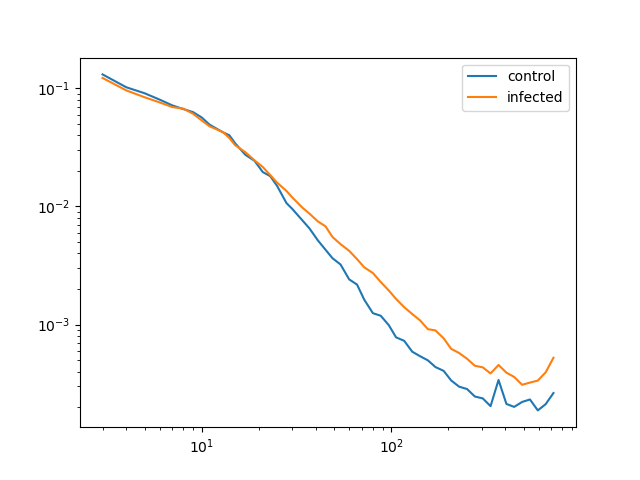

In [201]:
%matplotlib notebook
from hicstuff.hicstuff import distance_law_from_mat
x_ctl, y_ctl = distance_law_from_mat(clr_ctl.matrix(sparse=True, balance=False).fetch('scaffold_4'))
x_inf, y_inf = distance_law_from_mat(clr_inf.matrix(sparse=True, balance=False).fetch('scaffold_4'))
first = 3
x_ctl = x_ctl[first:]
y_ctl = y_ctl[first:]
x_inf = x_inf[first:]
y_inf = y_inf[first:]
plt.loglog(x_ctl, y_ctl/np.sum(y_ctl), label='control')
plt.loglog(x_inf, y_inf/np.sum(y_inf), label='infected')
plt.legend()


In [202]:
dc

,accession,mate,ctl_contacts,inf_contacts,baseMean,log2FoldChange,lfcSE,pvalue,padj,prop_change,chrom,start,end
0,VMHBD_00001,VMHBD_00002,0.042424,0.031779,3115.234270,0.025707,0.086490,7.637726e-01,9.016659e-01,-0.143462,scaffold_1,504,5457
1,VMHBD_00002,VMHBD_00003,0.051581,0.034323,3348.902663,-0.092367,0.117443,4.148381e-01,6.797663e-01,-0.200905,scaffold_1,5352,9953
2,VMHBD_00003,VMHBD_00002,0.051581,0.034323,3727.081400,-0.089744,0.175408,5.851130e-01,8.027713e-01,-0.200905,scaffold_1,9877,10656
3,VMHBD_00004,VMHBD_00001,0.038855,0.030869,10202.808114,-0.022690,0.113743,8.377438e-01,9.332530e-01,-0.114531,scaffold_1,10702,11622
4,VMHBD_00005,VMHBD_00006,0.026333,0.023900,12856.755216,0.055337,0.156946,7.168848e-01,8.775977e-01,-0.048431,scaffold_1,11710,30748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15439,VMHBD_16860,VMHBD_16859,0.048075,0.042799,5479.413183,-0.094952,0.105211,3.556935e-01,6.257805e-01,-0.058056,scaffold_9,1459272,1461957
15440,VMHBD_16861,VMHBD_16866,0.098604,0.089415,34524.103408,1.048034,0.123138,3.868048e-18,7.857093e-17,-0.048871,scaffold_9,1462016,1464847
15441,VMHBD_16862,VMHBD_16863,0.070841,0.198531,15143.512737,1.059915,0.108409,3.026278e-23,7.314185e-22,0.474029,scaffold_9,1466866,1468510
15442,VMHBD_16863,VMHBD_16862,0.070841,0.198531,8031.309566,1.262325,0.105837,1.373984e-33,4.381842e-32,0.474029,scaffold_9,1468226,1469982
